In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
from operator import itemgetter
import scipy
import random
from decimal import Decimal
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [2]:
#get directories and open separated datasets

savedir = 'D:/Aaron/Data/CK666/Data_and_Figs/'

nbins = 11
    
if os.path.exists(savedir + 'Shape_Metrics_transitionPCbins.csv'):
    
    TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)
    print('Opened binned PCs')
    
    #still need to calculate PC bins for later plots

    hist1, PC1bins = np.histogram(TotalFrame.PC1, nbins)
    hist2, PC2bins = np.histogram(TotalFrame.PC2, nbins)
    hist3, PC3bins = np.histogram(TotalFrame.PC3, nbins)
    hist4, PC4bins = np.histogram(TotalFrame.PC4, nbins)
    
else:
    from CustomFunctions import shapePCAtools
    from vtk.util import numpy_support
    import vtk
    from aicsshparam import shtools
    import pickle as pk
    
    
    #get directories
    TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_with_Digitized_PCs.csv')
    
    #remove the "Cell_" from PCs
    for x in TotalFrame.columns.to_list():
        if 'PC' in x:
            TotalFrame = TotalFrame.rename(columns = {x:x.replace('Cell_','')})
    #add a column that identifies cells across all frames
    TotalFrame['CellID'] = [x.split('_frame')[0] for x in TotalFrame.cell.to_list()]

    #Add Elongation metric
    TotalFrame['Cell_Elongation'] = TotalFrame['Cell_MajorAxis']/TotalFrame['Cell_MinorAxis']

    #sphericity calculation (ratio of surface area of circle with same volume to actual surface area)
    Cell_Sphere = []
    for index, row in TotalFrame.iterrows():
        #cell sphericity
        r = ((3*row.Cell_Volume)/(4*math.pi)) ** (1/3)
        SA = 4*math.pi*r
        Cell_Sphere.append(SA/row.Cell_SurfaceArea)
    TotalFrame['Cell_Sphericity'] = Cell_Sphere


    ######### Get angles of long axes relative to the axis of trajectory #############
    RelativeAngles = pd.DataFrame()
    vectors = sorted([i for i in row.index if 'MajorAxis_Vec' in i])
    # row = RandomRotations.iloc[0]
    for index, row in TotalFrame.iterrows():
        angles = {}
        arr = row[vectors].to_numpy()
        if arr[0] < 0:
            arr = arr*-1
        #get angle between the vector and the planes
        UpDownAngle = distance(arr[0], arr[1], arr[2], arr[0], arr[1], 0)
        LeftRightAngle = distance(arr[0], arr[1], arr[2], arr[0], 0, arr[2])
        TotalAngle = distance(arr[0], arr[1], arr[2], 1, 0, 0)
        #append angles
        rx = vectors[0].split('_')[0]
        angles[rx +'_UpDownAngle'] = UpDownAngle if arr[2]>0 else -1*UpDownAngle
        angles[rx +'_LeftRightAngle'] = LeftRightAngle if arr[1]>0 else -1*LeftRightAngle
        angles[rx +'_TotalAngle'] = TotalAngle
        RelativeAngles = RelativeAngles.append(angles, ignore_index=True)
    #add the angles to the dataframe and remove vectors
    TotalFrame = TotalFrame.merge(RelativeAngles, left_index = True, right_index = True)

    #add migration mode and speed
    treat = []
    for f in TotalFrame['cell'].to_list():
        if 'CK666' in f:
            treat.append('CK666')
        elif 'DMSO' in f:
            treat.append('DMSO')
    TotalFrame['Treatment'] = treat
            
            
    #first bin PCs
    hist1, PC1bins = np.histogram(TotalFrame.PC1, nbins)
    hist2, PC2bins = np.histogram(TotalFrame.PC2, nbins)
    hist3, PC3bins = np.histogram(TotalFrame.PC3, nbins)
    hist4, PC4bins = np.histogram(TotalFrame.PC4, nbins)
    TotalFrame['PC1bins'] = np.digitize(TotalFrame.PC1, PC1bins)
    TotalFrame['PC2bins'] = np.digitize(TotalFrame.PC2, PC2bins)
    TotalFrame['PC3bins'] = np.digitize(TotalFrame.PC3, PC2bins)
    TotalFrame['PC4bins'] = np.digitize(TotalFrame.PC4, PC2bins)
    
    
    ############ calculate the distance travelled between time points in the PC1-PC2 CGPS ##########
    to = []
    fromm = []
    idd = []
    for i, cells in TotalFrame.sort_values('frame').groupby('CellID'):
        runs = list()
        #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
        for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
            currentrun = list(map(itemgetter(1), g))
            list.append(runs, currentrun)

        for r in runs:
            r = np.array(r, dtype=int)
            cell = cells[cells.frame.isin(r)]
            tdiffs = cell[['PC1bins','PC2bins']].diff()
            fdiffs = cell[['PC1bins','PC2bins']].diff(-1)
            PC1_PC2_distance_to = []
            PC1_PC2_distance_from = []
            for d in range(len(cell)):
                #calculate the change distance the cell HAS travelled
                PC1_PC2_distance_to.append(np.sqrt(tdiffs.iloc[d].PC1bins**2 + tdiffs.iloc[d].PC2bins**2))
                #calculate the change distance the cell WILL travel
                PC1_PC2_distance_from.append(np.sqrt(fdiffs.iloc[d].PC1bins**2 + fdiffs.iloc[d].PC2bins**2))
            to.extend(PC1_PC2_distance_to)
            fromm.extend(PC1_PC2_distance_from)
            idd.extend(cell.cell.to_list())
    #add them to the the total dataframe
    TotalFrame = TotalFrame.merge(pd.DataFrame({'cell':idd,
                  'PC1_PC2_distance_to':to,
                  'PC1_PC2_distance_from':fromm}),
                  left_on = ['cell'],
                right_on = ['cell'])
    
    
    TotalFrame.to_csv(savedir + 'Shape_Metrics_transitionPCbins.csv')
    print('Calculated combined PCs and binned PCs')

Opened binned PCs


In [3]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


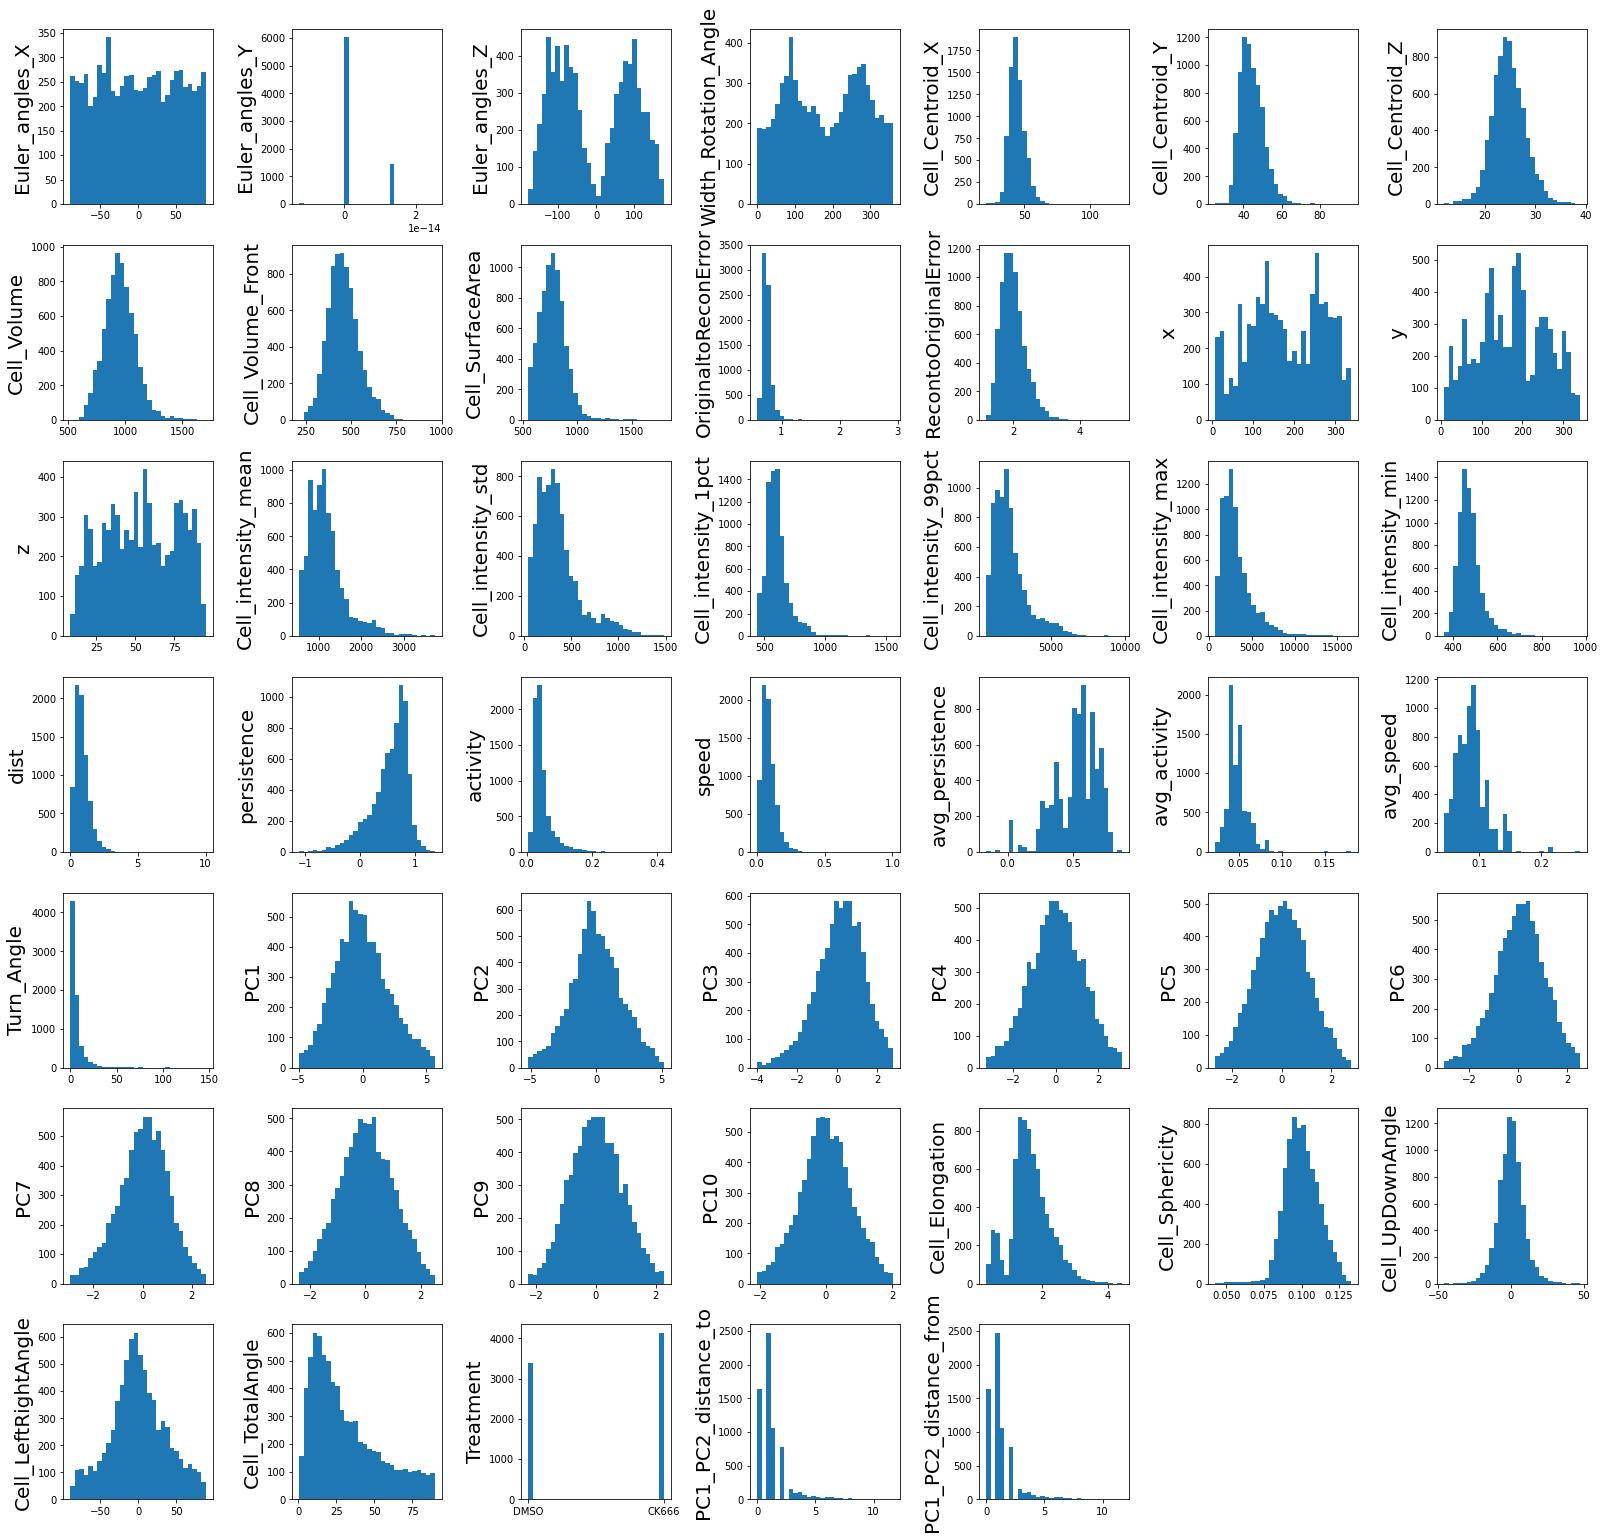

In [4]:
################# LOOK AT STAT DISTRIBUTIONS ######################


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame.drop(columns = to_remove)
smallerframe = smallerframe.drop(columns = ['cell','cell.1','CellID','structure','frame'])
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    ax.hist(smallerframe.iloc[:,i], 30)#, color=colors[i]) , 30, (-2,2))
    ax.set_ylabel(smallerframe.iloc[:,i].name, fontsize = 20)
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i+1,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()
# plt.savefig(folder_fl + 'Shape Metric Histograms.png', bbox_inches='tight')

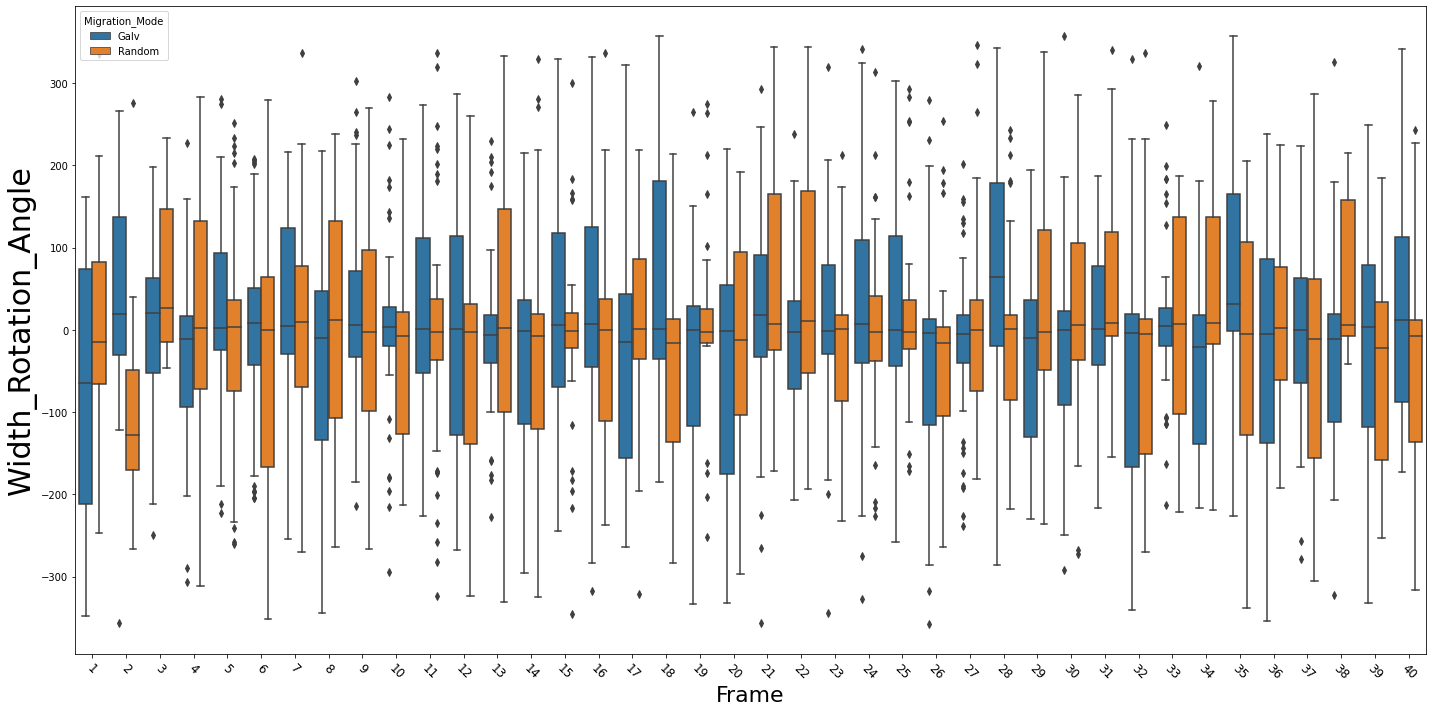

In [7]:
################ how much is rotation of the cell changing from frame to frame ###############

difflist = []
for i, d in TotalFrame[['CellID','Migration_Mode','frame','Width_Rotation_Angle']].sort_values(by='frame').groupby('CellID'):
    dtemp = d[['frame','Width_Rotation_Angle']].diff()
    dtemp = dtemp[dtemp.frame==1]
    dtemp['frame'] = d.frame[dtemp.index]
    dtemp['CellID'] =  [i]*len(dtemp)
    dtemp['Migration_Mode'] = d.Migration_Mode[dtemp.index]
    difflist.append(dtemp)
diffdf = pd.concat(difflist)

fig, ax = plt.subplots(1, 1, figsize=(20,10), sharey=True)

cpc = 'Width_Rotation_Angle'
sns.boxplot(data=diffdf, x='frame', hue='Migration_Mode',y=cpc, ax=ax)
ax.set_xticklabels(
    np.sort(diffdf.frame.unique()).astype(int),
    rotation=-45,
    fontsize = 12
    )
#set axis titles
ax.set_ylabel(cpc, fontsize = 30)
ax.set_xlabel('Frame', fontsize = 22)
plt.tight_layout()
# fig.savefig(savedir+'PC bin differentials.png', facecolor='white')

In [5]:
# get list of metrics that are significant by anova
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])


for c in ModeFrame.drop(columns=new_remove).columns.to_list()[:-1]:
    samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
    f_val, p_val = ss.ttest_ind(*samples)
    print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# for c in siglist:
#     print(f'Name {c}', pairwise_tukeyhsd(GeneFrame[c], GeneFrame['Gene']))
siglist
# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Name: Width_Rotation_Angle, F value: 2.176093686978999, p value: 0.02957928710565129
Name: Cell_Centroid_X, F value: 5.535387969312528, p value: 3.2100473540195366e-08
Name: Cell_Centroid_Y, F value: 3.52701421113583, p value: 0.000422781077991719
Name: Cell_Centroid_Z, F value: 8.41730125161552, p value: 4.568956453506474e-17
Name: Cell_Volume, F value: 13.798190524412654, p value: 8.658152860106233e-43
Name: Cell_Volume_Front, F value: 7.013575768757802, p value: 2.524943152661523e-12
Name: Cell_SurfaceArea, F value: 7.902165419444861, p value: 3.1310798913104423e-15
Name: OriginaltoReconError, F value: 3.42182686931301, p value: 0.0006253327287583166
Name: RecontoOriginalError, F value: 6.1001238708148575, p value: 1.1123508911180848e-09
Name: x, F value: 9.591363876319324, p value: 1.1561676828318346e-21
Name: y, F value: -9.783954123631288, p value: 1.7962847406336613e-22
Name: z, F value: 5.078009341392102, p value: 3.905758755697663e-07
Name: Cell_intensity_mean, F value: 0.8190

['Cell_Centroid_X',
 'Cell_Centroid_Y',
 'Cell_Centroid_Z',
 'Cell_Elongation',
 'Cell_Sphericity',
 'Cell_SurfaceArea',
 'Cell_Volume',
 'Cell_Volume_Front',
 'Cell_intensity_99pct',
 'Cell_intensity_max',
 'Cell_intensity_min',
 'OriginaltoReconError',
 'PC10',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'RecontoOriginalError',
 'Width_Rotation_Angle',
 'persistence',
 'speed',
 'x',
 'y',
 'z']

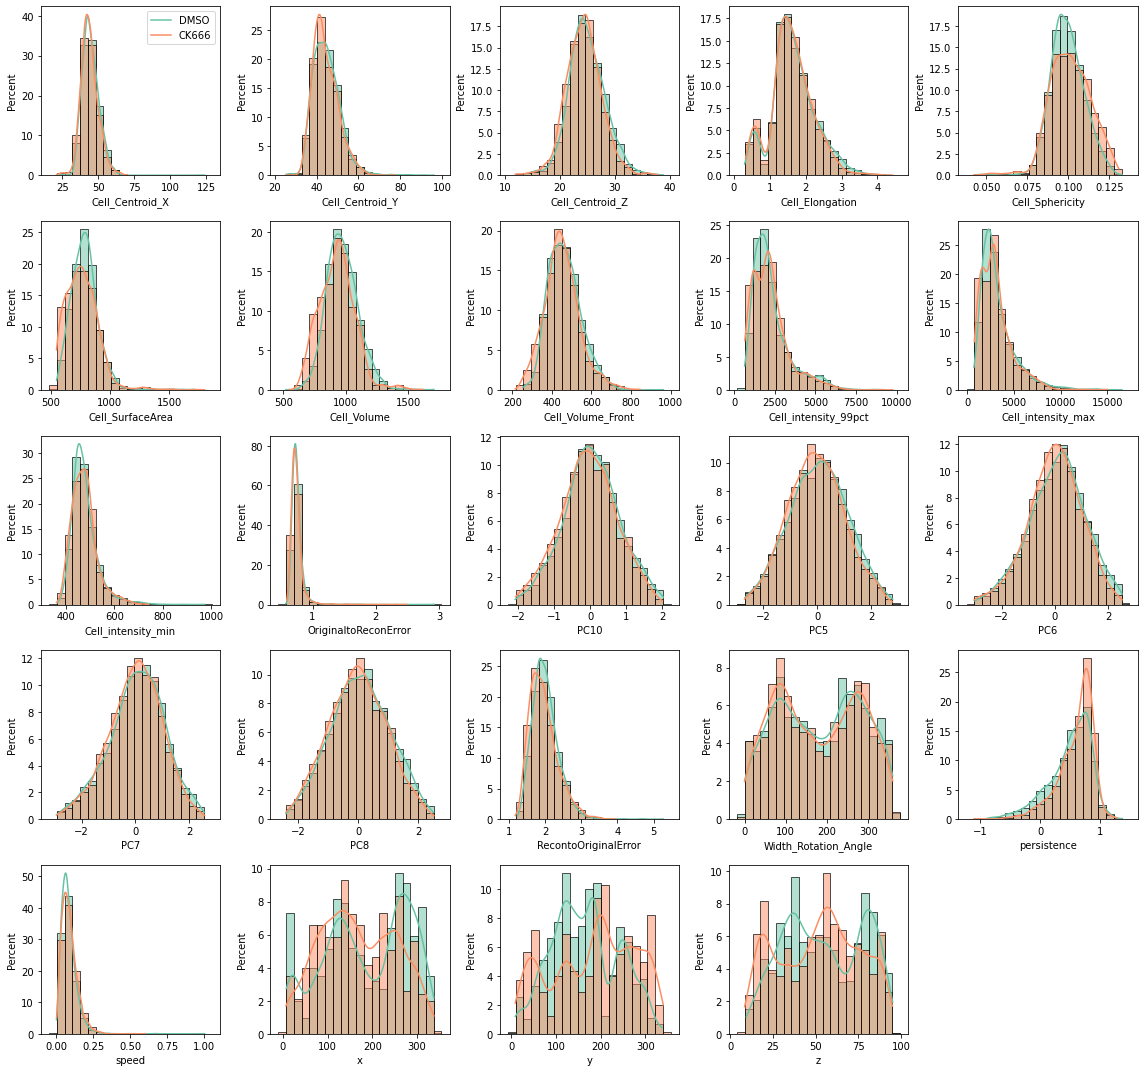

In [8]:
################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame[siglist]
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[0,0]
ax.legend(ModeFrame.Treatment.unique())

#delete all of the subplots that are unused
for a in range(i+1,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
plt.savefig(savedir + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

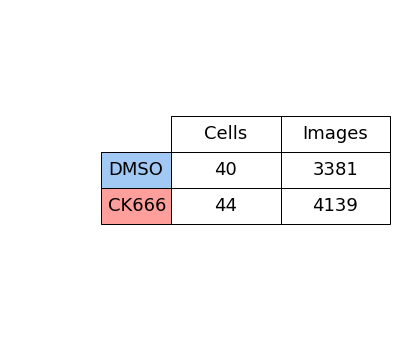

In [14]:
#get the number of images of cells and unique cells per migration mode
samplesize = pd.DataFrame([])

for m, mod in TotalFrame.groupby('Treatment'):
    imnum = len(mod)
    cellnum = len(mod.CellID.unique())
    samplesize = samplesize.append(pd.DataFrame({'Treatment':m.replace('_',' '),
                                                 'Cells':cellnum, 
                                                'Images':imnum}, index = [0]))

samplesize = samplesize.reset_index(drop=True)
samplesize.iloc[0], samplesize.iloc[1] = samplesize.iloc[1].copy(), samplesize.iloc[0].copy()
# samplesize['Treatment'] = ['DMSO','CK666']
samplesize



####### plot table of how many images and cells
fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
tb = ax.table(cellText=samplesize.values[:,1:],
      rowLabels=samplesize.values[:,0],
      rowColours=colorlist,
      colLabels=samplesize.columns[1:].to_list(),
        loc= 'center right',
        cellLoc = 'center',
        colWidths = [0.35]*len(samplesize))
tb.scale(0.8,3)
tb.auto_set_font_size(False)
tb.set_fontsize(18)
ax.axis('off')
plt.savefig(savedir + 'treatment significant metric table.png', bbox_inches='tight')




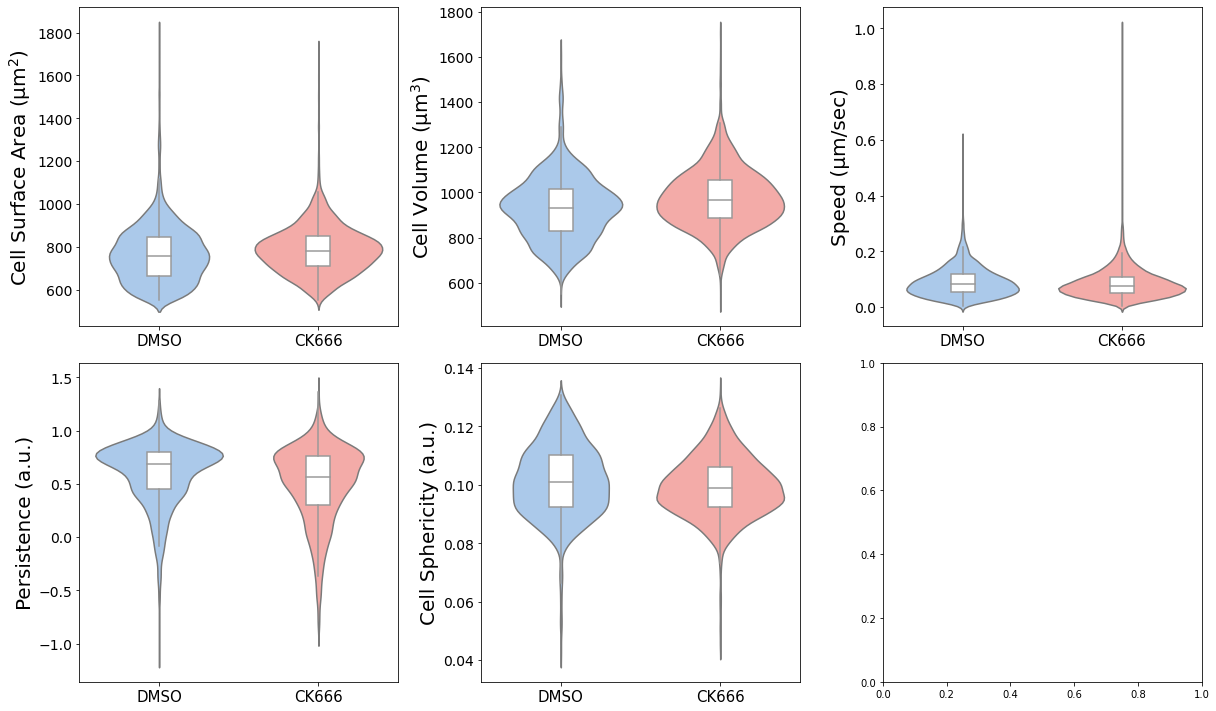

In [21]:
############### Metric distributions by gene #################################

import re


# #### remove speed outliers
tempframe = TotalFrame.copy()#[TotalFrame.speed<0.8]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Cell_Sphericity']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Speed (µm/sec)','Persistence (a.u.)','Cell Sphericity (a.u.)']


fig, axes = plt.subplots(2, 3, figsize=(17,10))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Migration_Mode'):
for i, sig in enumerate(smallersig):
    vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, palette = colorlist, inner = None, ax=axli[i], )
    bp = sns.boxplot(data=tempframe, x='Treatment', y=sig, width = 0.15, 
            color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(tempframe['Treatment'].unique(), fontsize = 15)


plt.tight_layout()
plt.savefig(savedir + 'treatment significant metric violins.png', bbox_inches='tight')




C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


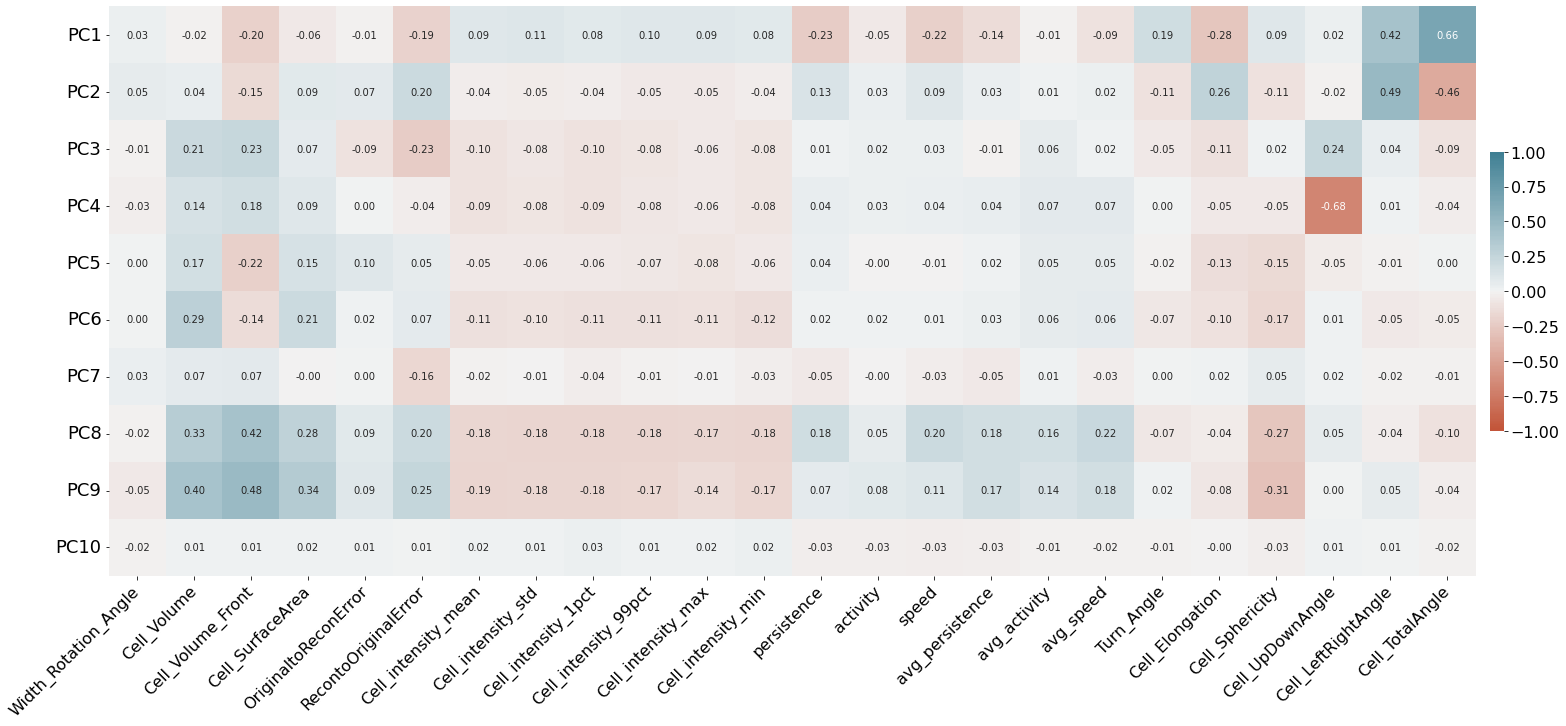

In [9]:
#correlations of shapes with PCs (PCs as rows)

coldrop = []
coldrop.extend([x for x in totalcorr.columns.to_list() if 'delta' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'PC' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist','x','y','z'])

PCsAndMetrics = totalcorr.loc[[x for x in totalcorr.index if 'PC' in x and 'delta' not in x and 'dist' not in x]]
PCsAndMetrics = PCsAndMetrics.drop(columns = coldrop)
fig, ax = plt.subplots(figsize=(25,15))
ax = sns.heatmap(
    PCsAndMetrics, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.2f',
    cbar_kws={'fraction':0.01, 'pad':0.01}#, 'shrink': 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 16
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    va = 'center',
    fontsize = 18
)
#scooch the x axis labels by a certain amount
dx = 6/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

plt.savefig(savedir + 'PC correlation with shape metrics heatmap.png', bbox_inches='tight')

In [56]:
TotalFrame.Cell_LeftRightAngle.max()

89.51684235318115

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


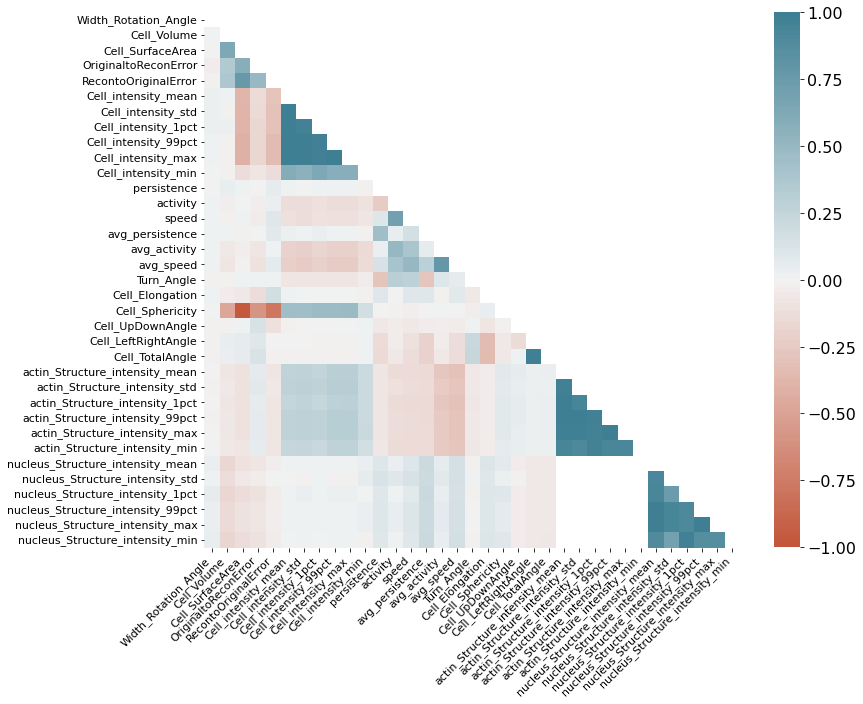

In [22]:
#get columns with nucleus and rows with cells from correlation matrix
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(1, -1.0, '−1.00'),
 Text(1, -0.75, '−0.75'),
 Text(1, -0.5, '−0.50'),
 Text(1, -0.25, '−0.25'),
 Text(1, 0.0, '0.00'),
 Text(1, 0.25, '0.25'),
 Text(1, 0.5, '0.50'),
 Text(1, 0.75, '0.75'),
 Text(1, 1.0, '1.00')]

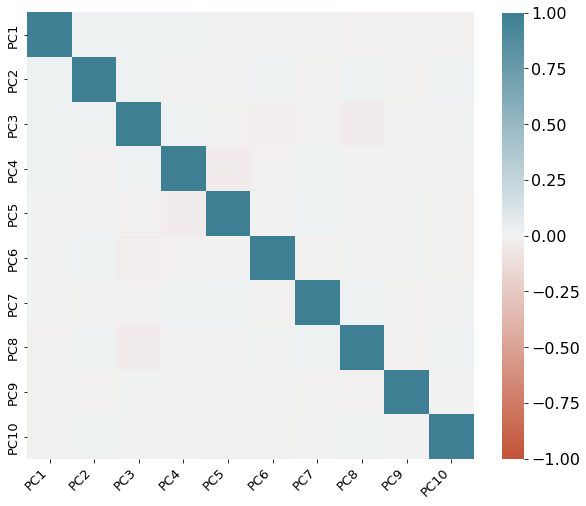

In [29]:
########################## PC Correlations #################

PCcorr = totalcorr.loc[[x for x in list(totalcorr.columns) if 'PC' in x]].loc[:,[x for x in list(totalcorr.columns) if 'PC' in x]]



#comparison of CELL features
fig, ax = plt.subplots(figsize=(len(PCcorr),len(PCcorr)))
ax = sns.heatmap(
    PCcorr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 13
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 13
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

# plt.savefig(folder_fl + 'Cell+Nuc Shape Metric corr rotationally aligned.png', bbox_inches='tight')

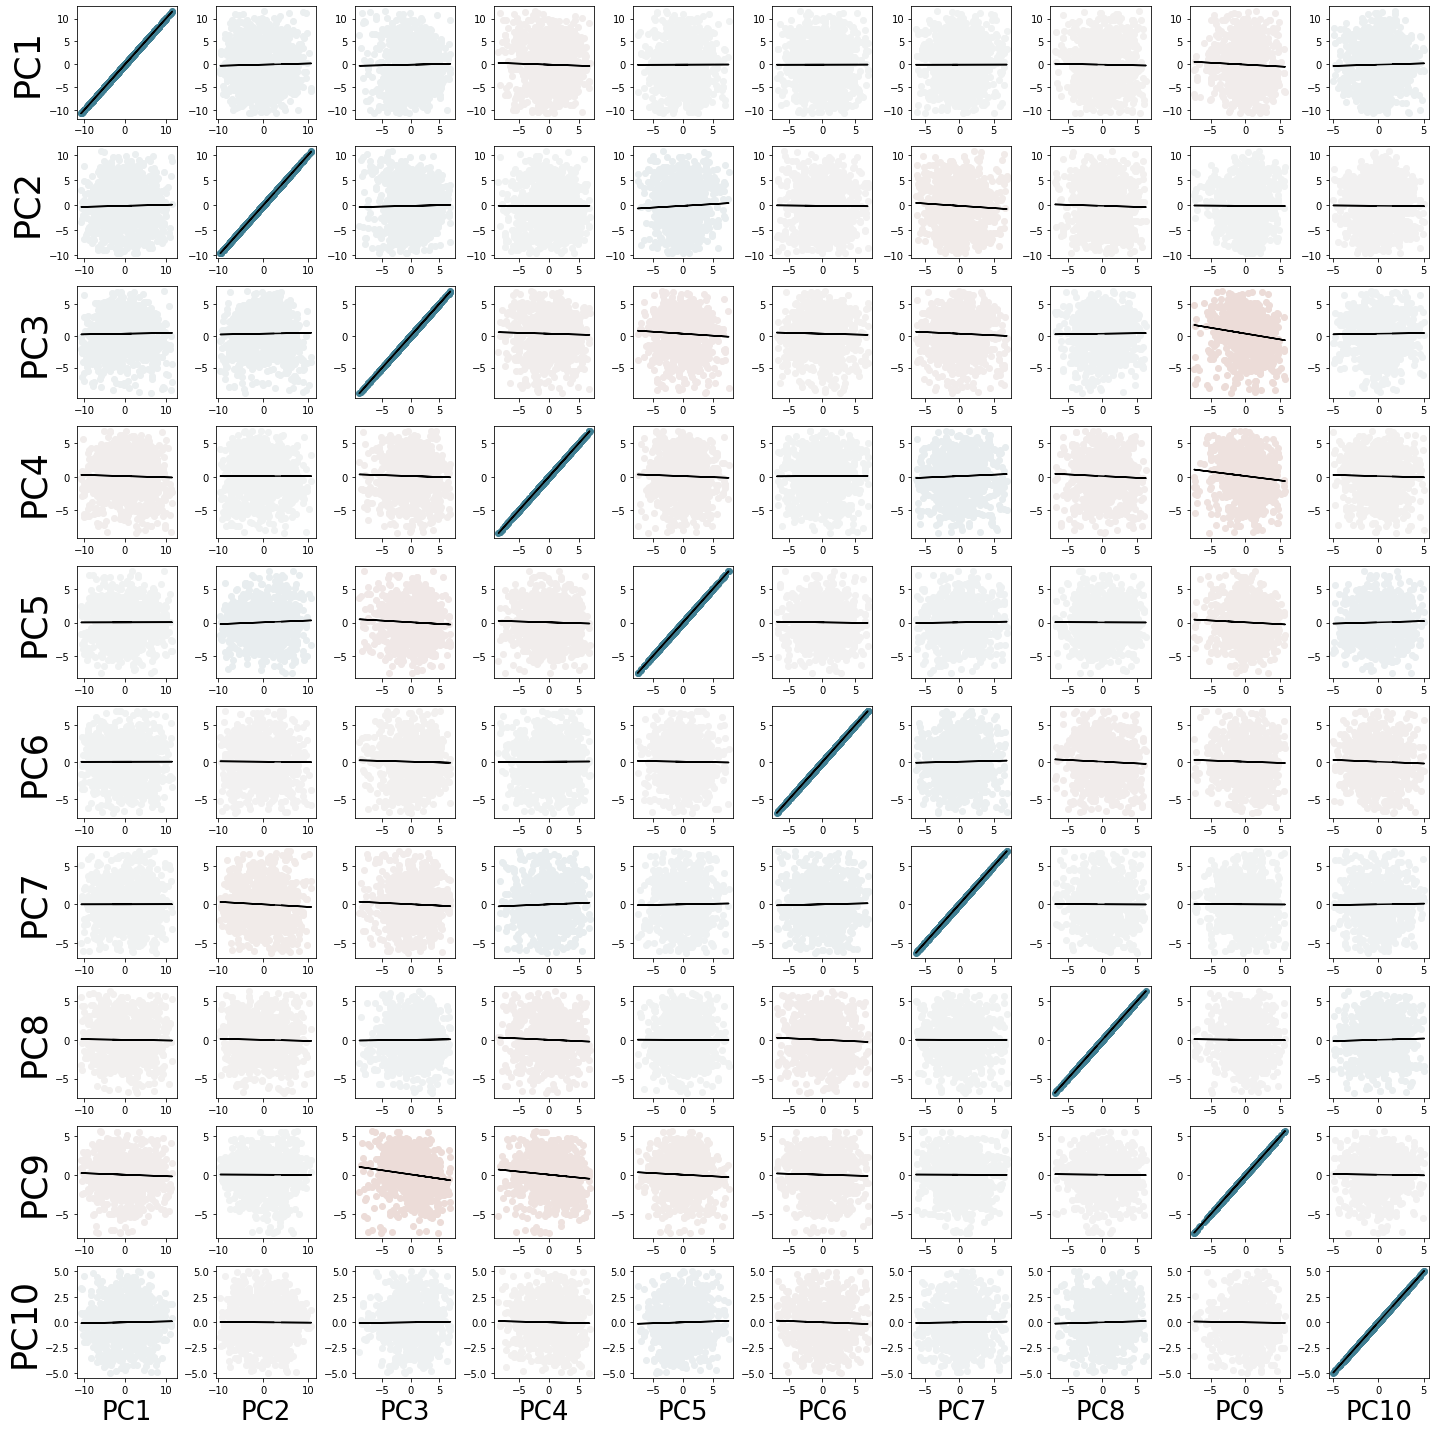

In [15]:
##################### look at scatter correlations between all PCs ###################

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(PC_frame.columns), figsize=(20,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = PC_frame[f'PC{i+1}']
        y = PC_frame[f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', f'PC{i+1}']
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')




# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
xlabels = PC_frame.columns
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 26) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

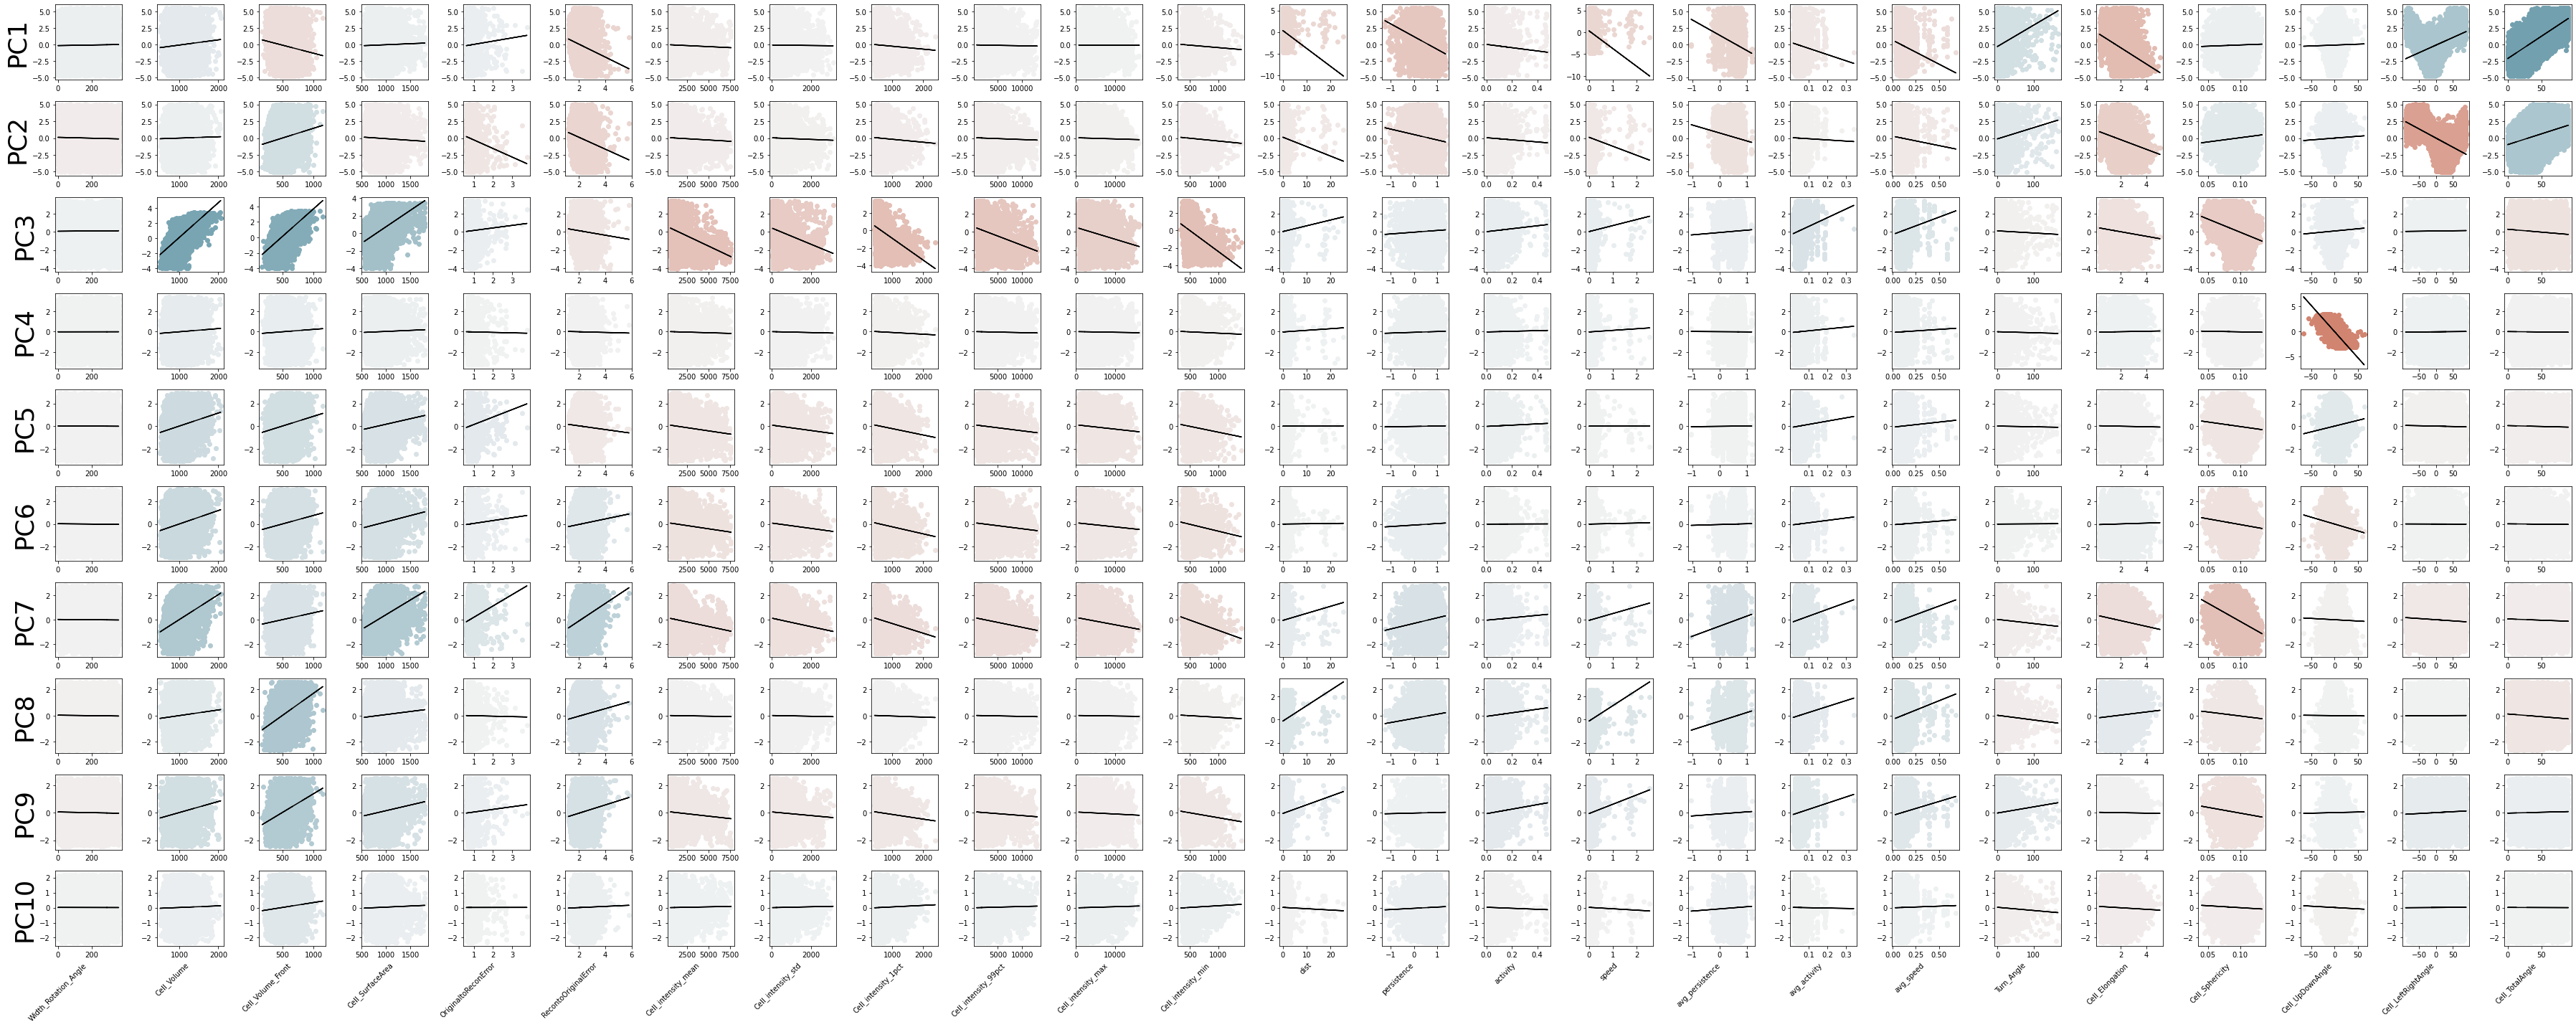

In [79]:
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'structure' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Migration' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Euler' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
coldrop.extend(to_remove)
coldrop.extend(['x','y','z','frame'])
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
metric_frame = TotalFrame.drop(columns=coldrop)

PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x and 'bin' not in x and 'delta' not in x and 'dist' not in x]]
# PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
# PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

cols = metric_frame.columns.to_list()
fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns),
                         figsize=(2*len(metric_frame.columns),2*len(PC_frame.columns)))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        rows = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()
        x = metric_frame.loc[rows,cols[i]]
        y = PC_frame.loc[rows,f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
#         ax.text(0.1,0.1,str(np.around(p_corr, decimals=2)))



# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
# xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(metric_frame.columns[i], rotation=45, horizontalalignment='right', fontsize = 10) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
plt.savefig(savedir+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

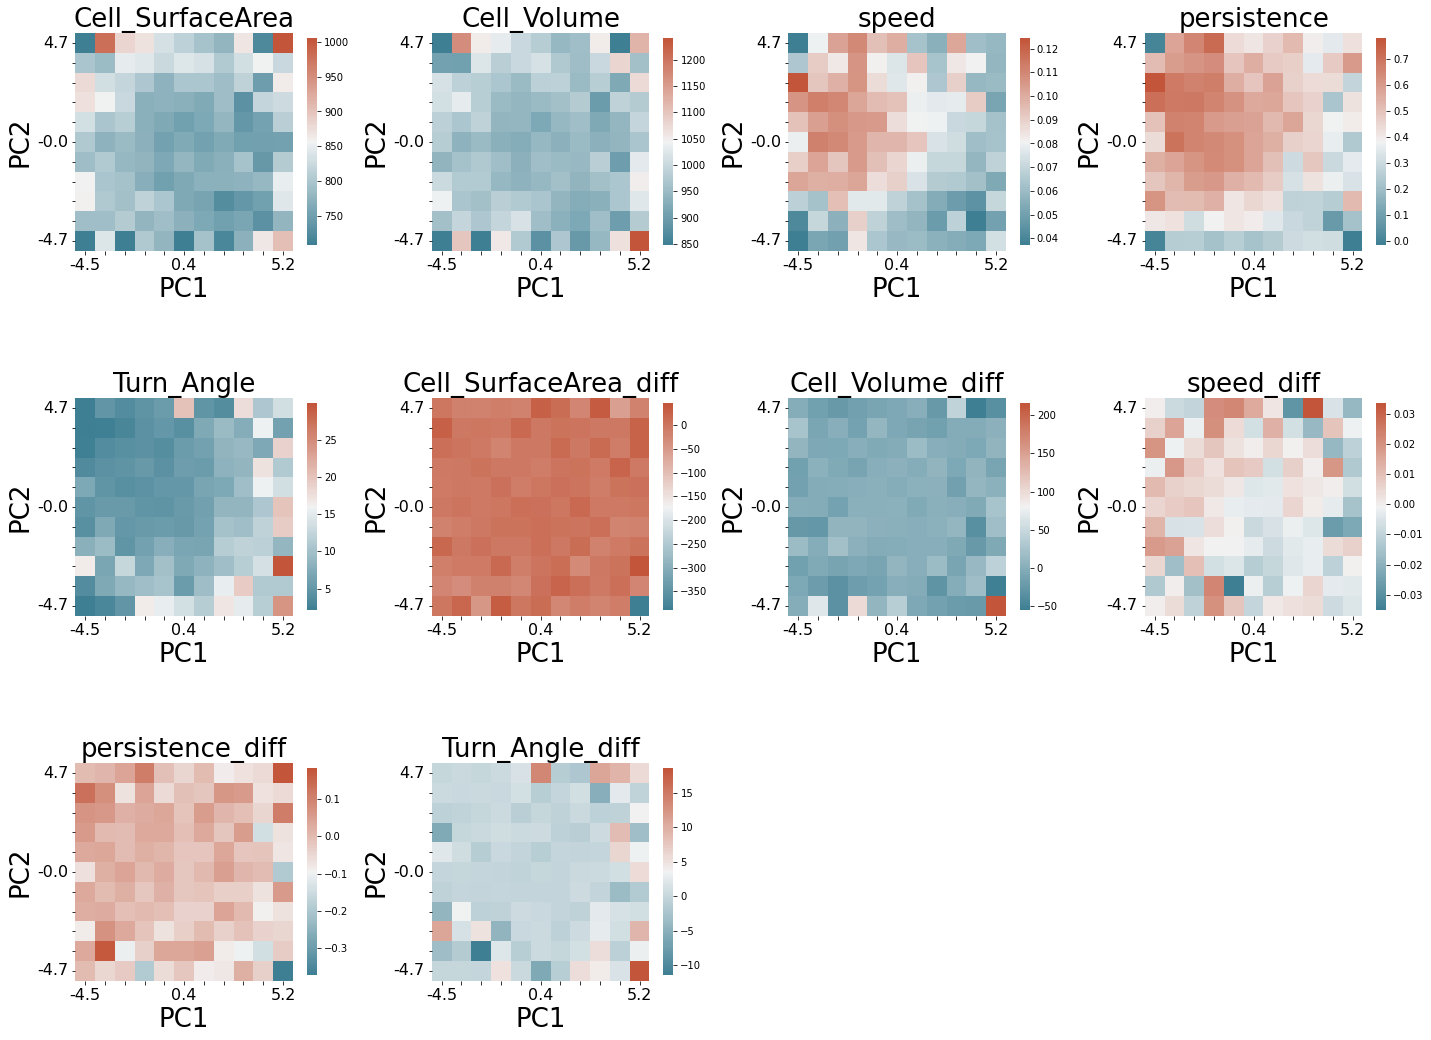

In [22]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

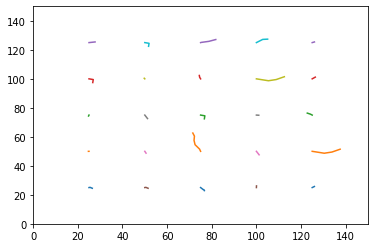

In [94]:
####### plot some example cell trajectories ############
#pick the square root of how many trajectories you want

howmany = 5
# avg_euc = []
# for i, cell in TotalFrame.sort_values('frame').reset_index(drop=True).groupby('CellID'):
#     pos = cell[['x','y','z']].to_numpy()
#     avg_euc.append(scipy.spatial.distance.pdist(np.array([pos[0], pos[-1]])))
# np.mean(avg_euc)
podi = 25
fig, ax = plt.subplots()
#make the plot square and big enough
lim = podi * (howmany+1)
ax.set_xlim(0, lim)
ax.set_ylim(0, lim)
#list of possible cells that have a given length of frames
numframe = 20
cells = []
for i, cell in TotalFrame.groupby('CellID'):
    if len(cell)>=numframe:
        cells.append(i)
# cells = TotalFrame.CellID.unique()
for x in range(howmany):
    for y in range(howmany):
        random.shuffle(cells)
        current = TotalFrame[TotalFrame.CellID == cells[0]]
        runs = list()
        #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
        for k, g in groupby(enumerate(current['frame']), lambda ix: ix[0] - ix[1]):
            currentrun = list(map(itemgetter(1), g))
            list.append(runs, currentrun)
        actualrun = max(runs, key=len, default=[])
        toplot = current[current.frame.isin(actualrun)]
        ax.plot(toplot.x.to_list()-toplot.x.values[0]+((x+1)*podi),toplot.y.to_list()-toplot.y.values[0]+((y+1)*podi))

#     #potentially select longest run
#     runs = list()
#     #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
#     for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
#         currentrun = list(map(itemgetter(1), g))
#         list.append(runs, currentrun)
#     actualrun = max(runs, key=len, default=[])

# np.array([cell.iloc[0][['x','y','z']], cell.iloc[len(cell)-1][['x','y','z']]])